# Predict the wind speed

A summarised set of methods and results

## Improvements

1. Include timestamp in the dataset?
1. Would be great if it can continue learning from AutoMLs current states!

In [48]:
import requests
from pathlib import Path
from tqdm import tqdm
import logging
import re
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import zipfile

from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import os

import pickle

In [49]:
target_turbine = "Kelmarsh_5"
autoML_duration_mins = 10

In [50]:
BYTES_MB = 1024 * 1024

In [51]:
def download_file(url: str, outfile: str | Path) -> None:
    """
    Download a file from the web, based on its url, and save to the outfile.

    Args:
        url(:obj:`str`): Url of data to download.
        outfile(:obj:`str` | :obj:`Path`): File path to which the download is saved.
    """

    outfile = Path(outfile).resolve()
    result = requests.get(url, stream=True)

    with outfile.open("wb") as f:
        for chunk in tqdm(result.iter_content(chunk_size=BYTES_MB), desc="MB downloaded"):
            if chunk:
                f.write(chunk)


In [52]:
def cos_curve(x, A, Offset, cos_exp):
    """Computes a cosine exponent curve as a function of yaw misalignment for curve fitting.

    Args:
        x (:obj:`float`): The yaw misalignment input in degrees.
        A (:obj:`float`): The amplitude of the cosine exponent curve.
        Offset (:obj:`float`): The yaw misaligment offset at which the cosine exponent curve is
            maximized in degrees.
        cos_exp (:obj:`float`): The exponent to which the cosine curve is raised.
    Returns:
        :obj:`float`: The value of the cosine exponent curve for the provided yaw misalignment.
    """
    return A * np.cos((np.pi / 180) * (x - Offset)) ** cos_exp

In [53]:
url = r"https://zenodo.org/records/8252025/files/Kelmarsh_12.3MW_6xSenvion_MM92.kmz?download=1"
outfile = Path("Kelmarsh_12.3MW_6xSenvion_MM92.kmz")

if not outfile.is_file():
    download_file(url,outfile)


In [54]:
data_path = "data/scada.csv"

if os.path.exists(data_path):
    # Load your existing predictor from its saved directory
    scada = pd.read_csv(data_path, index_col=0, parse_dates=True)
    
else:
    url = r"https://zenodo.org/records/8252025/files/Kelmarsh_SCADA_2022_4457.zip?download=1"
    outfile = Path("data/Kelmarsh_SCADA_2022_4457.zip")

    if not outfile.is_file():
        download_file(url,outfile)

    with zipfile.ZipFile(outfile,"r") as zip_ref:
        zip_ref.extractall()

    scada_files = list(Path().rglob("data/Turbine_Data*.csv"))

    use_columns = [
                "# Date and time",
                "Power (kW)",
                "Wind speed (m/s)",
                "Wind direction (°)",
                "Nacelle position (°)",
                "Blade angle (pitch position) A (°)",
            ]

    csv_params = {
            "index_col": "# Date and time",
            "parse_dates": True,
            "skiprows": 9,
            "usecols": use_columns,
        }

    print(str(scada_files[0])[-42:-32])

    scada_lst = []

    for file in scada_files:
        turbine_name = str(file)[-42:-32] # TODO - should take name of file not the full path

        scada_wt = pd.read_csv(file, **csv_params)

        scada_wt["Turbine"] = turbine_name
        scada_wt.index.names = ["Timestamp"]
        scada_lst.append(scada_wt.copy())

    scada = pd.concat(scada_lst)

    scada.to_csv("data/scada.csv")

In [55]:
scada

,Wind speed (m/s),Wind direction (°),Nacelle position (°),Power (kW),Blade angle (pitch position) A (°),Turbine
Timestamp,,,,,,
2022-01-01 00:00:00,6.781222,185.795348,193.731354,630.889598,0.0000,Kelmarsh_1
2022-01-01 00:10:00,6.936052,189.458687,193.731354,809.339449,0.0000,Kelmarsh_1
2022-01-01 00:20:00,7.294642,188.648729,193.731354,893.607333,0.0470,Kelmarsh_1
2022-01-01 00:30:00,8.080467,188.826550,193.731354,995.583734,0.0065,Kelmarsh_1
2022-01-01 00:40:00,7.021328,191.252213,193.731354,926.519441,0.0060,Kelmarsh_1
...,...,...,...,...,...,...
2022-12-31 23:10:00,8.712688,210.193670,205.457916,1447.101428,0.1090,Kelmarsh_6
2022-12-31 23:20:00,9.149686,208.465164,205.457916,1572.766687,0.3910,Kelmarsh_6
2022-12-31 23:30:00,9.571797,213.539677,205.457916,1653.457245,1.1805,Kelmarsh_6


In [56]:
scada["Yaw error"] = (scada["Nacelle position (°)"] - scada["Wind direction (°)"]+180)%360-180 # TODO - circular difference rather than absolute

In [57]:
scada["wind_direction_cos"]=np.cos(scada["Wind direction (°)"]*np.pi/180)
scada["wind_direction_sin"]=np.sin(scada["Wind direction (°)"]*np.pi/180)

In [58]:
scada = scada[["Wind speed (m/s)","wind_direction_cos","wind_direction_sin","Power (kW)","Blade angle (pitch position) A (°)","Turbine","Yaw error"]]

<Axes: xlabel='Timestamp'>

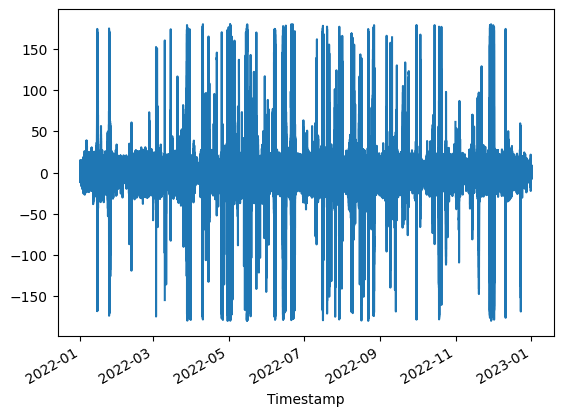

In [59]:
scada["Yaw error"].plot()

In [60]:
scada_clean = scada[(scada["Turbine"]!=target_turbine) 
                    | ((scada["Turbine"]==target_turbine) 
                        & (scada["Blade angle (pitch position) A (°)"]<1.5) 
                        & (scada["Blade angle (pitch position) A (°)"]>-1.5)
                        & (scada["Yaw error"]>-20)
                        & (scada["Yaw error"]<20)
                        )]

# scada_clean = scada.copy()


In [61]:
scada_clean

,Wind speed (m/s),wind_direction_cos,wind_direction_sin,Power (kW),Blade angle (pitch position) A (°),Turbine,Yaw error
Timestamp,,,,,,,
2022-01-01 00:00:00,6.781222,-0.994889,-0.100976,630.889598,0.0000,Kelmarsh_1,7.936005
2022-01-01 00:10:00,6.936052,-0.986404,-0.164336,809.339449,0.0000,Kelmarsh_1,4.272666
2022-01-01 00:20:00,7.294642,-0.988629,-0.150376,893.607333,0.0470,Kelmarsh_1,5.082625
2022-01-01 00:30:00,8.080467,-0.988157,-0.153444,995.583734,0.0065,Kelmarsh_1,4.904804
2022-01-01 00:40:00,7.021328,-0.980778,-0.195128,926.519441,0.0060,Kelmarsh_1,2.479140
...,...,...,...,...,...,...,...
2022-12-31 23:10:00,8.712688,-0.864330,-0.502924,1447.101428,0.1090,Kelmarsh_6,-4.735754
2022-12-31 23:20:00,9.149686,-0.879107,-0.476624,1572.766687,0.3910,Kelmarsh_6,-3.007247
2022-12-31 23:30:00,9.571797,-0.833503,-0.552514,1653.457245,1.1805,Kelmarsh_6,-8.081761


In [62]:
scada_clean = scada_clean.pivot(columns='Turbine').dropna().stack("Turbine").reset_index().set_index("Timestamp")

C:\Users\Charlie\AppData\Local\Temp\ipykernel_6780\4243526468.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  scada_clean = scada_clean.pivot(columns='Turbine').dropna().stack("Turbine").reset_index().set_index("Timestamp")


In [63]:
scada_target = scada_clean[scada_clean["Turbine"]==target_turbine]

In [64]:
scada_others = scada_clean[scada_clean["Turbine"]!=target_turbine]

In [65]:
scada_others

,Turbine,Wind speed (m/s),wind_direction_cos,wind_direction_sin,Power (kW),Blade angle (pitch position) A (°),Yaw error
Timestamp,,,,,,,
2022-01-01 00:00:00,Kelmarsh_1,6.781222,-0.994889,-0.100976,630.889598,0.0000,7.936005
2022-01-01 00:00:00,Kelmarsh_2,6.649725,-0.995992,-0.089440,630.786577,0.0000,8.279502
2022-01-01 00:00:00,Kelmarsh_3,6.526749,-0.981500,-0.191464,593.362961,0.0000,0.054329
2022-01-01 00:00:00,Kelmarsh_4,6.736784,-0.996176,-0.087373,613.850131,0.0000,6.363253
2022-01-01 00:00:00,Kelmarsh_6,6.133781,-0.993237,-0.116108,444.272346,0.0000,7.437901
...,...,...,...,...,...,...,...
2022-12-31 23:20:00,Kelmarsh_1,9.730098,-0.900639,-0.434567,1572.972638,0.9735,3.339510
2022-12-31 23:20:00,Kelmarsh_2,9.295921,-0.901414,-0.432958,1642.098862,0.4495,7.510591
2022-12-31 23:20:00,Kelmarsh_3,7.491813,-0.873131,-0.487485,948.692542,0.0090,3.867630


In [66]:
X = scada_others.pivot(columns='Turbine')
y = scada_target

In [67]:
X.columns = [re.sub(r'[^a-zA-Z_0-9]','', '_'.join(map(str, col)).strip()) for col in X.columns]

In [68]:
X["yaw_error"] = scada_target["Yaw error"] # adding yaw error as a feature, so it can be used in determining what yaw error provides optimal power 

In [69]:
X

,Windspeedms_Kelmarsh_1,Windspeedms_Kelmarsh_2,Windspeedms_Kelmarsh_3,Windspeedms_Kelmarsh_4,Windspeedms_Kelmarsh_6,wind_direction_cos_Kelmarsh_1,wind_direction_cos_Kelmarsh_2,wind_direction_cos_Kelmarsh_3,wind_direction_cos_Kelmarsh_4,wind_direction_cos_Kelmarsh_6,...,BladeanglepitchpositionA_Kelmarsh_2,BladeanglepitchpositionA_Kelmarsh_3,BladeanglepitchpositionA_Kelmarsh_4,BladeanglepitchpositionA_Kelmarsh_6,Yawerror_Kelmarsh_1,Yawerror_Kelmarsh_2,Yawerror_Kelmarsh_3,Yawerror_Kelmarsh_4,Yawerror_Kelmarsh_6,yaw_error
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,6.781222,6.649725,6.526749,6.736784,6.133781,-0.994889,-0.995992,-0.981500,-0.996176,-0.993237,...,0.0000,0.0000,0.0000,0.000,7.936005,8.279502,0.054329,6.363253,7.437901,15.093580
2022-01-01 00:10:00,6.936052,7.172483,7.795904,6.162219,5.848290,-0.986404,-0.976280,-0.979874,-0.986540,-0.988479,...,0.0145,0.1960,0.0000,0.000,4.272666,0.906545,-0.421944,-5.459333,-6.295805,13.313166
2022-01-01 00:20:00,7.294642,7.092553,7.577127,6.058528,5.683789,-0.988629,-0.968040,-0.981631,-0.980613,-0.984083,...,0.0000,0.0000,0.0000,0.000,5.082625,-1.113780,0.093829,2.522211,-7.826455,4.286828
2022-01-01 00:30:00,8.080467,7.185699,7.774836,6.851648,6.080469,-0.988157,-0.971962,-0.974693,-0.961614,-0.969137,...,0.0000,0.0180,0.0000,0.000,4.904804,-0.188826,-1.824809,-0.999015,-11.862085,6.997161
2022-01-01 00:40:00,7.021328,7.110317,7.358590,7.567326,6.682785,-0.980778,-0.956558,-0.949077,-0.953696,-0.951591,...,0.0245,0.0000,0.0155,0.000,2.479140,-3.539474,-7.270820,-2.576542,-10.367238,-2.241580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 22:40:00,8.943925,8.998160,9.182801,8.787624,7.316843,-0.732187,-0.718023,-0.678224,-0.807669,-0.686508,...,0.2790,0.2095,0.1245,0.000,4.825872,-0.522117,1.113954,7.332962,-2.474310,6.601432
2022-12-31 22:50:00,8.366701,8.588931,6.869543,7.945592,7.511415,-0.808731,-0.844547,-0.741831,-0.851596,-0.788441,...,0.0000,0.0000,0.0000,0.000,4.479713,9.570002,6.296594,9.010378,6.156532,-8.622895
2022-12-31 23:00:00,9.200417,9.562916,6.708959,7.662811,7.326496,-0.846370,-0.888515,-0.785716,-0.893659,-0.849881,...,0.7225,0.0000,0.0000,0.000,3.501678,5.451175,7.907457,2.532536,1.370319,1.181715


# AutoML Wind Speed

In [70]:
target_feature = "Wind speed (m/s)"

In [71]:
model_path = f"AutogluonModels/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}_{target_turbine}_{autoML_duration_mins:02d}mins"

if os.path.exists(model_path):
    # Load your existing predictor from its saved directory
    predictor = TabularPredictor.load(model_path)

else:
    # Training with AutoGluon
    predictor = TabularPredictor(
        label=target_feature, 
        eval_metric='mae',
        path=model_path,
    )
    predictor.fit(
        train_data=pd.concat([X,y[target_feature]],axis=1), 
        time_limit=60*autoML_duration_mins, 
        presets='best_quality', 
        num_gpus='auto', 
        num_cpus='auto',
    )

In [72]:
prediction_path = f"predictions/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}_{target_turbine}_{autoML_duration_mins:02d}mins.pkl"

if os.path.exists(prediction_path):
    # Load your existing predictor from its saved directory
    # Open the file for reading in binary mode
    with open(prediction_path, "rb") as file:
        # Load (deserialize) the object from the file
        target_prediction = pickle.load(file)

else:
    target_prediction = predictor.predict(X)

    # Open a file for writing in binary mode
    with open(prediction_path, "wb") as file:
        # Serialize and save the object to the file
        pickle.dump(target_prediction, file)

In [73]:
target_prediction.name = "target_prediction"

In [75]:
target_result = pd.concat([X,y,target_prediction],axis=1)

np.mean(abs(target_result["target_prediction"]-target_result[target_feature]))

0.1345016136788098

In [76]:
X_tmp = X.copy()
X_tmp["yaw_error"] = 0

prediction_path = f"predictions/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}_yaw0_{target_turbine}_{autoML_duration_mins:02d}mins.pkl"

if os.path.exists(prediction_path):
    # Load your existing predictor from its saved directory
    # Open the file for reading in binary mode
    with open(prediction_path, "rb") as file:
        # Load (deserialize) the object from the file
        target_prediction_yaw0 = pickle.load(file)

else:
    target_prediction_yaw0 = predictor.predict(X_tmp)

    # Open a file for writing in binary mode
    with open(prediction_path, "wb") as file:
        # Serialize and save the object to the file
        pickle.dump(target_prediction_yaw0, file)

In [77]:
target_prediction_yaw0.name = "target_prediction_yaw0"

In [78]:
target_result = pd.concat([X,y,target_prediction_yaw0],axis=1)

np.mean(abs(target_result["target_prediction_yaw0"]-target_result[target_feature]))

0.1822387607582157

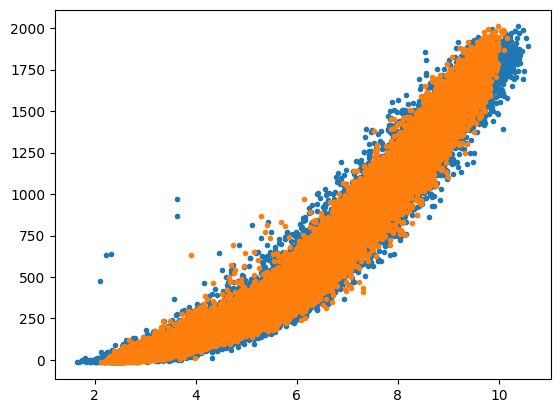

In [79]:
plt.figure()
plt.plot(target_result["Wind speed (m/s)"],target_result["Power (kW)"],marker='.',linestyle='')
plt.plot(target_result["target_prediction_yaw0"],target_result["Power (kW)"],marker='.',linestyle='')

plt.savefig(f"images/{target_turbine}_wind_speed_power_curve_{autoML_duration_mins:02d}mins.png")

plt.show()

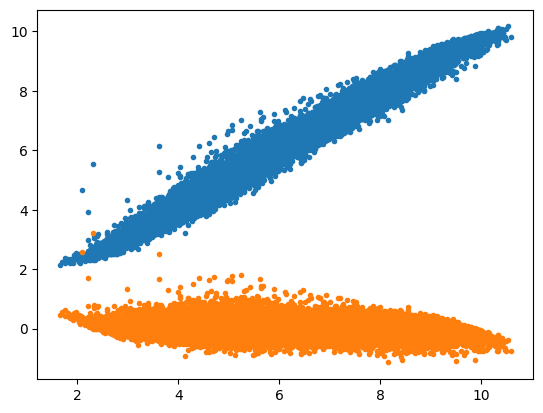

In [80]:
plt.figure()
plt.plot(target_result["Wind speed (m/s)"],target_result["target_prediction_yaw0"],marker='.',linestyle='')
plt.plot(target_result["Wind speed (m/s)"],target_result["target_prediction_yaw0"]-target_result["Wind speed (m/s)"],marker='.',linestyle='')

plt.savefig(f"images/{target_turbine}_wind_speed_comparison_{autoML_duration_mins:02d}mins.png")

plt.show()

In [81]:
ws_bins=[5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
vane_bins=np.linspace(-25,25,51)

target_result['yaw_bin'] = pd.cut(target_result['Yaw error'], vane_bins)

# target_result_filtered['ws_bin'] = pd.cut(target_result_filtered['Wind speed (m/s)'], ws_bins)
target_result['ws_bin'] = pd.cut(target_result['target_prediction_yaw0'], ws_bins)

In [82]:
target_result_sye = target_result.groupby(by=["ws_bin","yaw_bin"]).agg(
    Median=("Power (kW)", 'median'),
    Count=("Power (kW)", 'count'),
    Mean=("Power (kW)", 'mean'))

target_result_sye = target_result_sye.reset_index()


C:\Users\Charlie\AppData\Local\Temp\ipykernel_6780\2066444576.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  target_result_sye = target_result.groupby(by=["ws_bin","yaw_bin"]).agg(


In [83]:
target_result_sye["ws_bin_left"] = pd.IntervalIndex(target_result_sye['ws_bin']).left
target_result_sye["yaw_bin_left"] = pd.IntervalIndex(target_result_sye['yaw_bin']).left

sye_data = target_result_sye.dropna()

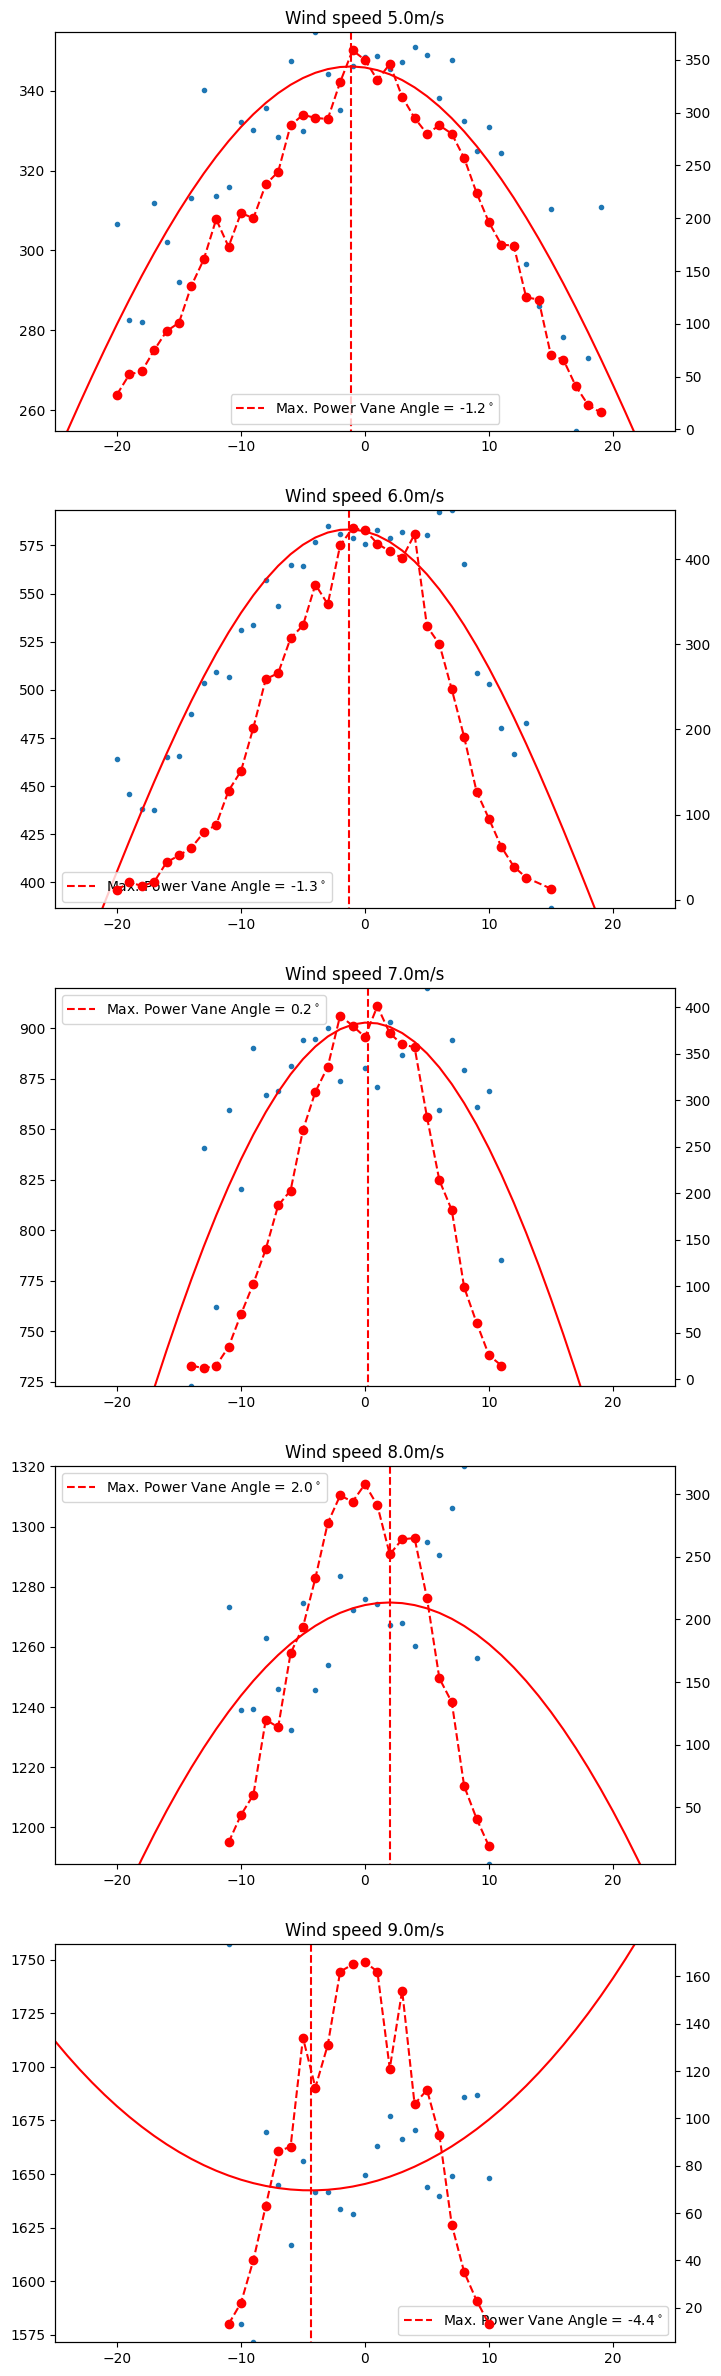

In [84]:
total_sub_figures =  len(set(sye_data["ws_bin_left"]))

fig = plt.figure(figsize=(8, 6*total_sub_figures))
i = 0

for ws_bin in set(sye_data["ws_bin_left"]):
    sye_ws_bin = sye_data[sye_data["ws_bin_left"]==ws_bin]
    
    sye_ws_bin = sye_ws_bin[sye_ws_bin["Count"]>10] # filter out bins with low counts
       
    i = i+1
    ax = plt.subplot(total_sub_figures, 1, i)  # (nrows, ncols, index)

    ax.plot(sye_ws_bin["yaw_bin_left"],sye_ws_bin["Median"],marker=".",linestyle="")

    curve_fit_params = curve_fit(cos_curve, 
            sye_ws_bin["yaw_bin_left"], 
            sye_ws_bin["Median"], 
            [sye_ws_bin["Median"].max(), 0.0, 2.0],
            maxfev=1000)[0]

    ax.plot(vane_bins,cos_curve(vane_bins,*curve_fit_params),c="red")
    
    ax.plot(
        2*[curve_fit_params[1]],
        [
                sye_ws_bin["Median"].max(),
                sye_ws_bin["Median"].min(),
        ],
        color="red",
        linestyle="--",
        label=rf"Max. Power Vane Angle = {round(curve_fit_params[1],1)}$^\circ$",  # noqa: W605
        )
    
    ax2 = ax.twinx()
    ax2.plot(sye_ws_bin["yaw_bin_left"], sye_ws_bin["Count"], marker="o", linestyle="--", color="red", label="Count")

    plt.title(f"Wind speed {ws_bin}m/s")
    
    ax.legend()
    ax.set_xlim([-25,25])
    ax.set_ylim([sye_ws_bin["Median"].min(),sye_ws_bin["Median"].max()])

plt.savefig(f"images/{target_turbine}_wind_speed_yaw_analysis_{autoML_duration_mins:02d}mins.png")

plt.show()

# AutoML Power

In [85]:
target_feature = "Power (kW)"

In [86]:
model_path = f"AutogluonModels/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}_{target_turbine}_{autoML_duration_mins:02d}mins"

if os.path.exists(model_path):
    # Load your existing predictor from its saved directory
    predictor = TabularPredictor.load(model_path)

else:    
    # Training with AutoGluon
    predictor = TabularPredictor(
        label=target_feature, 
        eval_metric='mae',
        path=model_path,
    )
    predictor.fit(
        train_data=pd.concat([X,y[target_feature]],axis=1), 
        time_limit=60*autoML_duration_mins, 
        presets='best_quality', 
        num_gpus='auto', 
        num_cpus='auto',
    )

In [87]:
prediction_path = f"predictions/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}_{target_turbine}_{autoML_duration_mins:02d}mins.pkl"

if os.path.exists(prediction_path):
    # Load your existing predictor from its saved directory
    # Open the file for reading in binary mode
    with open(prediction_path, "rb") as file:
        # Load (deserialize) the object from the file
        target_prediction = pickle.load(file)

else:
    target_prediction = predictor.predict(X)

    # Open a file for writing in binary mode
    with open(prediction_path, "wb") as file:
        # Serialize and save the object to the file
        pickle.dump(target_prediction, file)



In [88]:
target_prediction.name = "target_prediction"

In [89]:
target_result = pd.concat([X,y,target_prediction],axis=1)

np.mean(abs(target_result["target_prediction"]-target_result[target_feature]))

19.35193607022562

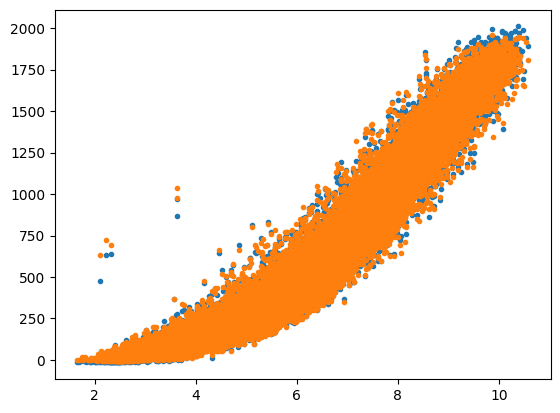

In [90]:
plt.figure()
plt.plot(target_result["Wind speed (m/s)"],target_result["Power (kW)"],marker='.',linestyle='')
plt.plot(target_result["Wind speed (m/s)"],target_result["target_prediction"],marker='.',linestyle='')

plt.savefig(f"images/{target_turbine}_power_power_curve_{autoML_duration_mins:02d}mins.png")

plt.show()

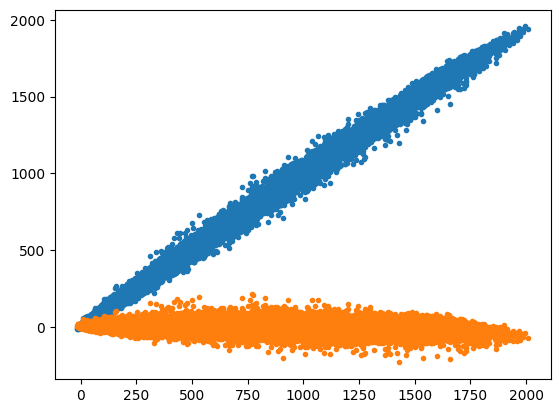

In [91]:
plt.figure()
plt.plot(target_result[target_feature],target_result["target_prediction"],marker='.',linestyle='')
plt.plot(target_result[target_feature],target_result["target_prediction"]-target_result[target_feature],marker='.',linestyle='')
# plt.ylim([-5,20])

plt.savefig(f"images/{target_turbine}_power_comparison_{autoML_duration_mins:02d}mins.png")

plt.show()

# Using power predictions for SYE estimates

In [92]:
X_tmp = X.copy()
X_tmp["yaw_error"] = 0

prediction_path = f"predictions/{re.sub(r'[^a-zA-Z_0-9]','', target_feature.strip())}_yaw0_{target_turbine}_{autoML_duration_mins:02d}mins.pkl"

if os.path.exists(prediction_path):
    # Load your existing predictor from its saved directory
    # Open the file for reading in binary mode
    with open(prediction_path, "rb") as file:
        # Load (deserialize) the object from the file
        target_prediction_yaw0 = pickle.load(file)

else:
    target_prediction_yaw0 = predictor.predict(X_tmp)

    # Open a file for writing in binary mode
    with open(prediction_path, "wb") as file:
        # Serialize and save the object to the file
        pickle.dump(target_prediction_yaw0, file)

In [93]:
yaw_bins = range(-10,11,1)
yaw_bin = pd.cut(X["yaw_error"],yaw_bins)
yaw_level = list(pd.IntervalIndex(yaw_bin).mid)

In [94]:
power_bins = range(0,2500,250)
power_bin = pd.cut(target_prediction,power_bins)
power_level = list(pd.IntervalIndex(power_bin).mid)

In [95]:
target_result = pd.DataFrame(target_prediction.copy())

In [96]:
target_result["yaw_level"] = yaw_level
target_result["power_level"] = power_level
target_result["target_prediction"] = target_prediction
target_result["target_prediction_yaw0"] = target_prediction_yaw0
target_result["Power (kW)"] = y["Power (kW)"]

In [97]:
# target_result = target_result.groupby(by=["power_level","yaw_level"])[["power_delta_actual","power_delta_model","power_delta_model"]].agg([["mean","mean","count"]])

target_result = target_result.groupby(by=["power_level","yaw_level"]).agg(
    target_prediction = ('target_prediction', 'mean'),
    target_prediction_yaw0 = ('target_prediction_yaw0', 'mean'),
    power_actual = ('Power (kW)', 'mean'),
    power_delta_count = ('target_prediction_yaw0', 'count')
)
target_result = pd.DataFrame(target_result)

In [98]:
target_result = target_result[target_result['power_delta_count'] >= 10]

In [99]:
target_result

target_prediction  target_prediction_yaw0  \
power_level yaw_level                                              
125.0       -9.5              126.434212              133.186111   
            -8.5              126.351974              132.566193   
            -7.5              125.796959              130.991577   
            -6.5              127.500420              131.523239   
            -5.5              119.062202              121.788170   
...                                  ...                     ...   
1875.0       4.5             1811.732422             1793.270874   
             5.5             1805.910034             1777.708496   
             6.5             1817.031982             1787.345825   
             7.5             1836.180054             1810.981079   
             8.5             1819.056152             1786.820801   

                       power_actual  power_delta_count  
power_level yaw_level                                   
125.0       -9.5         124.921166                343  
            -8.5         124.983331                392  
            -7.5         124.042064                434  
            -6.5         125.915608                426  
            -5.5         117.687310                437  
...                             ...                ...  
1875.0       4.5        1828.999577                 28  
             5.5        1826.007366                 31  
             6.5        1837.094452                 18  
             7.5        1851.292242                 12  
             8.5        1837.143144                 11  

[157 rows x 4 columns]

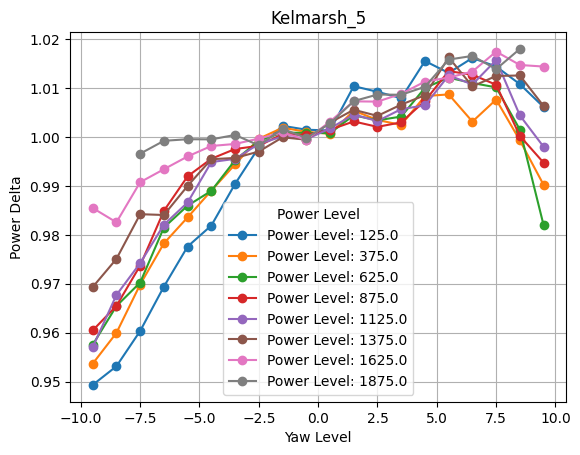

In [100]:
plt.figure()

# Group by the first level of the MultiIndex, e.g., 'power_level'
for power_level, group in target_result.groupby(level='power_level'):
    # Extract the 'yaw_level' values from the second index level
    yaw_levels = group.index.get_level_values('yaw_level')
    plt.plot(yaw_levels, group['target_prediction']/group['target_prediction_yaw0'], marker='o', linestyle='-', label=f'Power Level: {power_level}')

plt.xlabel('Yaw Level')
plt.ylabel('Power Delta')
plt.legend(title='Power Level')
plt.title(target_turbine)
plt.grid(True)

plt.savefig(f"images/{target_turbine}_power_model_{autoML_duration_mins:02d}mins.png")

plt.show()

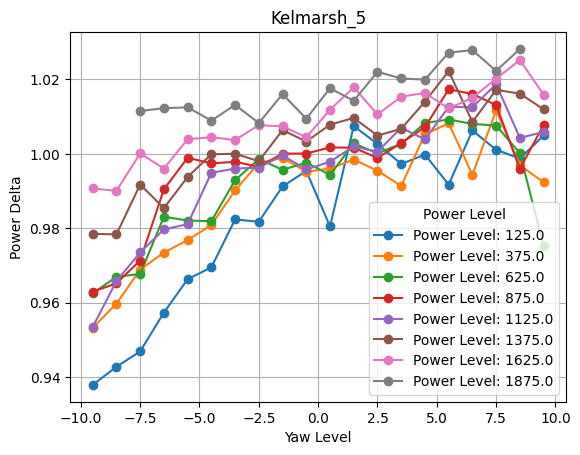

In [101]:
plt.figure()

# Group by the first level of the MultiIndex, e.g., 'power_level'
for power_level, group in target_result.groupby(level='power_level'):
    # Extract the 'yaw_level' values from the second index level
    yaw_levels = group.index.get_level_values('yaw_level')
    plt.plot(yaw_levels, group['power_actual']/group['target_prediction_yaw0'], marker='o', linestyle='-', label=f'Power Level: {power_level}')

plt.xlabel('Yaw Level')
plt.ylabel('Power Delta')
plt.legend(title='Power Level')
plt.title(target_turbine)
plt.grid(True)

plt.savefig(f"images/{target_turbine}_power_actual_{autoML_duration_mins:02d}mins.png")

plt.show()

# Change in performance over time?

Compare expect power to actual

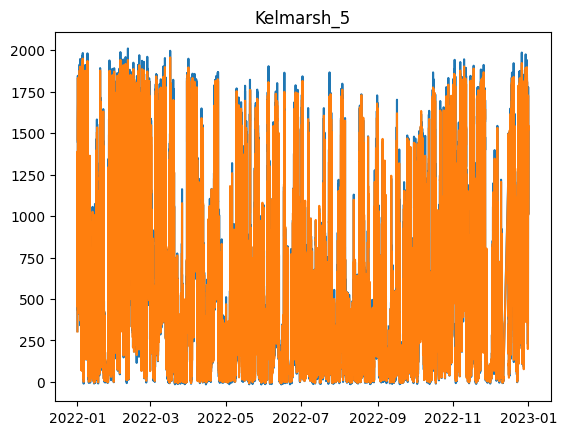

In [102]:
plt.figure()
plt.plot(y[target_feature])
plt.plot(target_prediction)
# plt.ylim([-5,20])
plt.title(target_turbine)

plt.savefig(f"images/{target_turbine}_power_timeseries_{autoML_duration_mins:02d}mins.png")

plt.show()

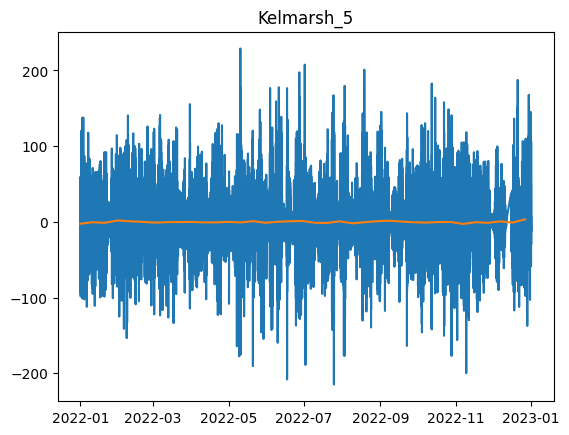

In [103]:
plt.figure()
plt.plot(y[target_feature]-target_prediction)
plt.plot((y[target_feature]-target_prediction).resample("10D").median())
# plt.ylim([-5,20])
plt.title(target_turbine)

plt.savefig(f"images/{target_turbine}_power_delta_timeseries_{autoML_duration_mins:02d}mins.png")

plt.show()